## Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

## Importing and Preparing the Dataset

In [3]:
# Importing the data
data = pd.read_csv('battery_suite_1.csv').drop(columns='Unnamed: 0').set_index('fish_id')

In [4]:
data.loc[data.Kc == data.Kc.max()] # Identifying incorrect values for Kc (normal values are around 1)

,group,treatment,exposure,datetime,latency,first_choice,num_changes,time_bright,mtpc,mov_bottom,...,time_in_last_flux,resistance_index,lt,ls,wt,Kc,sex,blood_sugar,conductivity,pH
fish_id,,,,,,,,,,,,,,,,,,,,,
1BT24hCTR09,24h 0.0%,0.0,24,2020-08-11 12:38:45,0.0,bright,20.0,95.0,4.75,194.0,...,55.0,44.25,3.3,2.7,3.9,19.814053,female,109.0,70.0,7.4


In [5]:
data.loc[data['group'] == '24h 0.0%', 'wt'] = data.loc[data['group'] == '24h 0.0%', 'wt'] / 10 # Correcting weight values

In [6]:
# Correcting Fulton's Condition Factor (Kc)
data['Kc'] = (data['wt'] / (data['ls'] ** 3)) * 100

In [7]:
data.datetime = pd.to_datetime(data.datetime) # setting datetime to timestamp

In [8]:
# data.head().round(2) # visualizing final dataset

In [9]:
data = data.fillna(-1) # filling Nans in upper portion velocity, -1 for fish that didn't get to explore the area

In [10]:
data.loc[data.first_choice == -1, 'first_choice'] = 'none' # Correcting values for first_choice

---

## Principal Components Analysis (PCA)

The **KMeans algorithm** clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster. The means are commonly called the cluster “centroids”; note that they are not, in general, points from $X$, although they live in the same space.

The K-means algorithm aims to choose centroids that minimise the **inertia**, or **within-cluster sum-of-squares criterion**:

$$
\sum_{i=0}^{n} \underset{\mu_j \in C}{\text{min}} \left( | x_i - \mu_j |^2 \right)
$$

Inertia can be recognized as a measure of how internally coherent clusters are.

### Scaling the Data

In [12]:
df = data.copy(deep=True)

In [13]:
df = df.select_dtypes(include=[np.number])

In [14]:
df.columns

Index(['treatment', 'exposure', 'latency', 'num_changes', 'time_bright',
       'mtpc', 'mov_bottom', 'mov_upper', 'mov_total', 'dist_bottom',
       'dist_upper', 'dist_total', 'vel_bottom', 'vel_upper', 'vel_mean',
       'attempts', 'last_flux', 'time_in_last_flux', 'resistance_index', 'lt',
       'ls', 'wt', 'Kc', 'blood_sugar', 'conductivity', 'pH'],
      dtype='object')

In [15]:
scaler = StandardScaler()
scaler.fit(df) # we scale the data

StandardScaler()

In [19]:
scaled_data = scaler.fit_transform(df)
scaled_data

array([[-1.22712061, -0.97198046, -0.33513879, ..., -0.26277043,
        -0.83490786, -0.82089578],
       [-1.22712061, -0.97198046, -0.33513879, ..., -1.12222449,
        -0.83490786, -0.82089578],
       [-1.22712061, -0.97198046,  0.66510205, ..., -0.26277043,
        -0.83490786, -0.82089578],
       ...,
       [ 1.24530018,  1.36135056, -0.33513879, ..., -1.06027171,
         1.07345296,  2.25181504],
       [ 1.24530018,  1.36135056, -0.33513879, ...,  0.07965949,
         1.07345296,  2.25181504],
       [ 1.24530018,  1.36135056, -0.33513879, ..., -0.86202281,
         1.07345296,  2.25181504]])

### Deciding the Number of Components and Clusters

In [20]:
pca = PCA(n_components=len(scaled_data)) # in order to retain all information, let's start with all components

In [16]:
pca_data_df = pd.DataFrame(pca_data, columns=data.columns)

In [17]:
pca_components = pca.fit_transform(pca_data)

In [18]:
explained_variance = pca.explained_variance_ratio_

In [19]:
explained_variance.cumsum()

array([0.19556456, 0.3759583 , 0.488926  , 0.56924148, 0.63556091,
       0.69257706, 0.74305598, 0.78566988, 0.82549876, 0.85728562,
       0.88759525, 0.91483904, 0.93411537, 0.95223477, 0.96602394,
       0.97807101, 0.98830012, 0.99283526, 0.99559405, 0.99739966,
       0.99883025, 0.99938792, 0.99974062, 1.        , 1.        ,
       1.        ])

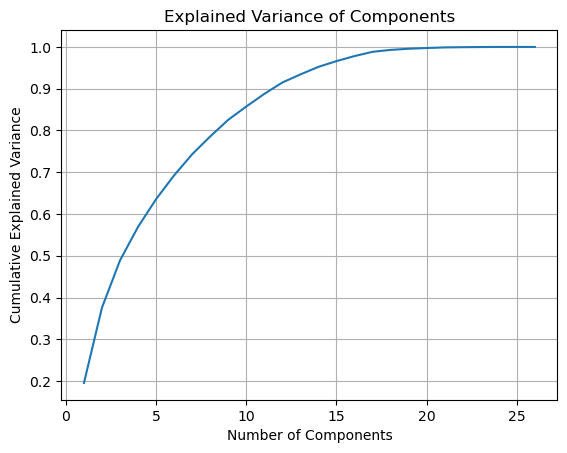

In [20]:
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum())

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance of Components')
plt.grid(True)
plt.show()

Looks like we achieve a good explanation of our variables between the 15th and 20th components. But I want to retain all the varaibles, so we are going to work with all 26 components here.

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

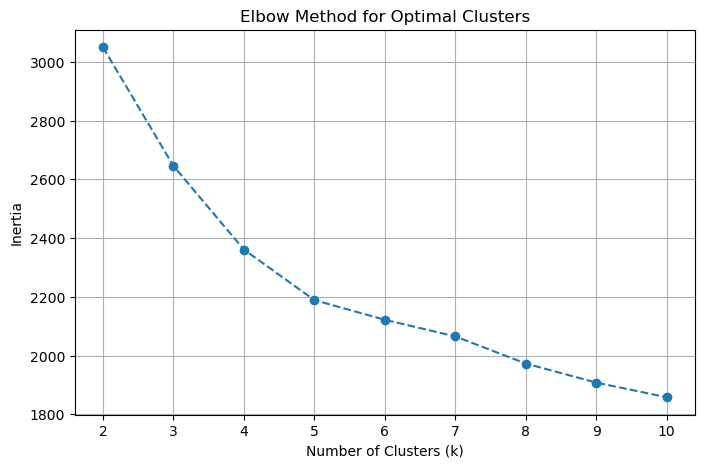

In [32]:
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)
    inertia.append(kmeans.inertia_)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

In [33]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(pca_components)
cluster_labels = kmeans.labels_
data['Cluster'] = cluster_labels

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


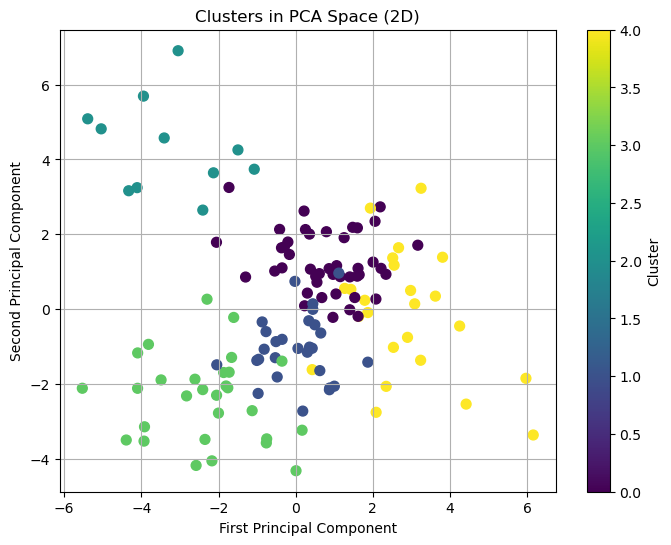

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title('Clusters in PCA Space (2D)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [22]:
num_data = data.select_dtypes(include=[np.number])

In [23]:
scaler = StandardScaler()

In [24]:
pca_data = scaler.fit_transform(num_data)

In [25]:
pca = PCA(n_components=2)

In [26]:
df = pd.DataFrame(data=pca.fit_transform(pca_data), columns=['PC1', 'PC2'])

In [27]:
groups = pd.read_csv('battery_suite_1.csv').pop('group')

In [28]:
df['groups'] = groups

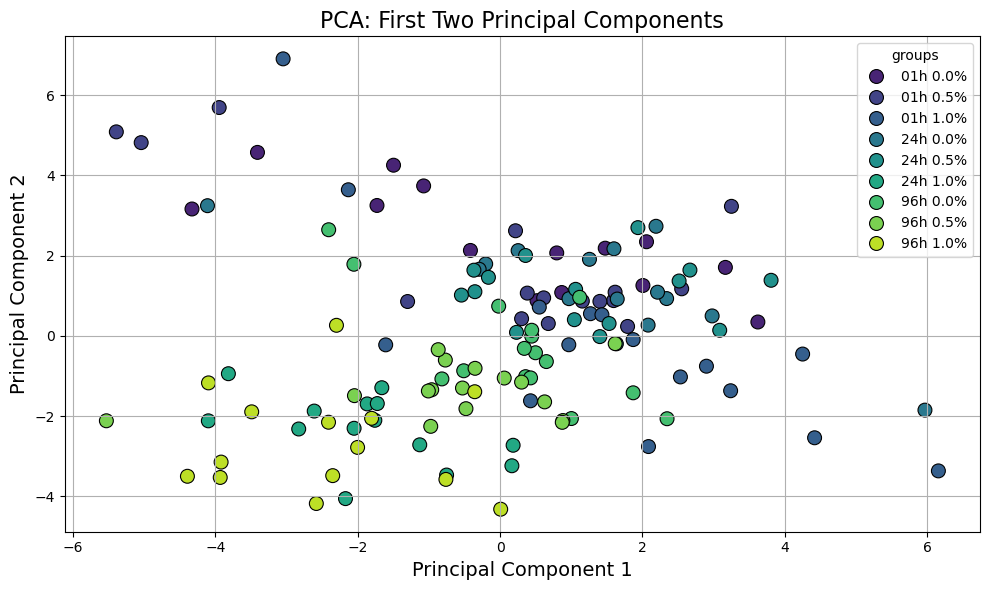

In [29]:
# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='groups', palette='viridis', s=100, edgecolor='k')
plt.title('PCA: First Two Principal Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
df

,PC1,PC2,groups
0,-1.729178,3.252408,01h 0.0%
1,-4.328256,3.164726,01h 0.0%
2,3.165249,1.708814,01h 0.0%
3,0.865968,1.082907,01h 0.0%
4,2.006578,1.257505,01h 0.0%
...,...,...,...
131,-2.581316,-4.177487,96h 1.0%
132,-1.805042,-2.053418,96h 1.0%
133,0.008708,-4.319292,96h 1.0%
134,-0.355920,-1.390563,96h 1.0%


In [31]:
pd.DataFrame(
    pca.components_, 
    columns=num_data.columns,  # Ensure you pass the original feature names here
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

,treatment,exposure,latency,num_changes,time_bright,mtpc,mov_bottom,mov_upper,mov_total,dist_bottom,...,last_flux,time_in_last_flux,resistance_index,lt,ls,wt,Kc,blood_sugar,conductivity,pH
PC1,-0.109868,-0.124164,0.066719,0.161285,-0.129931,-0.156455,0.091182,0.175265,0.243555,0.260211,...,0.232011,0.096539,0.244180,0.211866,0.207193,0.228744,0.123775,-0.014983,-0.109036,-0.175559
PC2,-0.228848,-0.229527,0.109695,-0.087033,-0.242840,-0.131887,-0.124622,-0.095303,-0.201507,-0.202410,...,0.166640,-0.047121,0.163495,0.288069,0.271991,0.265391,0.096662,-0.142461,-0.146966,-0.261987
